# System of Differential Equations

In [25]:
# !pip install deepxde  # Run this line if you are in Google Colab

Let's motivate this section with  the __Lotka-Volterra equations__, also known as the predator-prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact. The populations change through time according to the pair of equations:
$$
\begin{align*}
    \dfrac{dx}{dt} &= \alpha x - \beta xy \\
    \dfrac{dy}{dt} &= -\gamma y + \delta xy
\end{align*}
$$
where
- $x$ is the number of prey;
- $y$ is the number of some predator;
- ${\tfrac {dy}{dt}}$ and ${\tfrac {dx}{dt}}$ represent the instantaneous growth rates of the two populations;
- $t$ represents time;
- $\alpha$, $\beta$, $\gamma$ and $\delta$ are positive real parameters describing the interaction of the two species.

We will need the following packages, `numpy` for array operations, `matplotlib` for visualizations and `scipy` for getting for getting a numerical solution with Runge-Kutta method.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

For this module we will use the following values of  $\alpha$, $\beta$, $\gamma$ and $\delta$.

In [27]:
alpha = 2 / 3
beta = 4 / 3
gamma = 1
delta = 1

It is important to decide a time invertal where we will working on. As an example let's consider between $t=0$ and $t=1$. As well as initial conditions $x(0)$ and $y(0)$.

In [28]:
t_initial = 0
t_final = 10

x0 = 1.2
y0 = 0.8

## Runge-Kutta

 Note we can modularize this step creating a function, for instance, `runge_kutta` which takes as input an array of time steps, initial conditions and the values of the parameters that describe the interaction between the two species. 

In [29]:
def runge_kutta(
    t,
    x0,
    y0,
    alpha,
    beta,
    gamma,
    delta
):

    def func(t, Y):
        x, y = Y
        dx_dt = alpha * x - beta * x * y
        dy_dt = - gamma * y  + delta * x * y
        return dx_dt, dy_dt

    Y0 = [x0, y0]
    t_span = (t[0], t[-1])
    sol = solve_ivp(func, t_span, Y0, t_eval=t)
    x_true, y_true = sol.y
    return x_true, y_true

Now, let's generate an time array and solve the initial value problem.

In [30]:
t_array = np.linspace(t_initial, t_final, 100)
x_rungekutta, y_rungekutta = runge_kutta(t_array, x0, y0, alpha, beta, gamma, delta)

We suggest you to plot your results since it can give you better insights of your simulations or predictions.

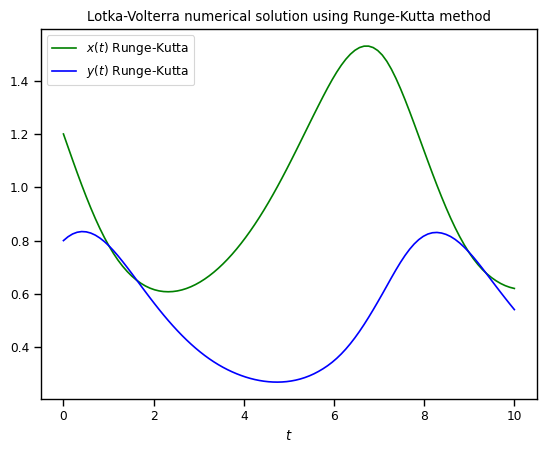

In [31]:
plt.plot(t_array, x_rungekutta, color="green", label=r"$x(t)$ Runge-Kutta")
plt.plot(t_array, y_rungekutta, color="blue", label=r"$y(t)$ Runge-Kutta")
plt.legend()
plt.xlabel(r"$t$")
plt.title("Lotka-Volterra numerical solution using Runge-Kutta method")
plt.show()

## PINNs for solving ODEs

For our Lotka-Volterra system the solution $u$ will be a vector such that
$$
u(t) = (x(t), y(t))^\top
$$
and there are not boundary conditions, only initial conditions.

We want to train a network that looks like this

![lotka_volterra_pinn](../../images/lotka_volterra_pinn.png)

The most important package is `deepxde`, which allows us to implement Physic-Informed Neural Networks approaches with a few lines of code. 

In [32]:
import deepxde as dde
from deepxde.backend import tf

## ODE Residuals

Since we are trying to embed the physics onto the neural networks we need to define 

In [33]:
def ode(t, Y):
    x = Y[:, 0:1]
    y = Y[:, 1:2]

    dx_dt = dde.grad.jacobian(Y, t, i=0)
    dy_dt = dde.grad.jacobian(Y, t, i=1)
    
    return [
        dx_dt - alpha * x + beta * x * y,
        dy_dt + gamma * y  - delta * x * y
    ]

Here `t` is the indepent variable and `Y` is an array with two columns (since our system considers two equations). To define the first derivative is as easy as using `dde.grad.jacobian`, just be sure about the component `i`, in this case we decided `i=0` corresponds to the variable $x(t)$ and `i=1` to $y(t)$.

## Initial conditions

And now we need to declare this element for our neural network, if not, the algorithm wouldn't know where to make the estimations.

In [34]:
geom = dde.geometry.TimeDomain(t_initial, t_final)

Then we have to create a function for defining boundaries, since our geometry it is only on time we will use the default one, don't worry about it.

In [35]:
def boundary(_, on_initial):
    return on_initial

And then we have to tell to our algorithm these are the initial conditions for the learning process

In [36]:
ic_x = dde.icbc.IC(geom, lambda x: x0, boundary, component=0)
ic_y = dde.icbc.IC(geom, lambda x: y0, boundary, component=1)

## Data object

Everything related to the differential equations and initial conditions has to be inside a new object `dde.data.PDE` (do not worry, it also consider systems of ordinary differential equations).

In [37]:
data = dde.data.PDE(
    geom,
    ode,
    [ic_x, ic_y],
    num_domain=512,
    num_boundary=2
)

In order to test our model we need more points, we considered 512 points inside our domain with `num_domain=512`. Finally, since we are working on a time domain there are only two points in its boundary (`num_boundary=2`).

## Neural Network

It is time for choosing a neural network architecture. For simplicity, we will use a Fully-connected neural network (`dde.nn.FNN'). The most important things are:

- Input layer (the first one) needs only one node/neuron since our indepent variable is only time $t$.
- The output layer (the last one) nneds two nodes/neurons since we are working on a system of two equations.

Do not worry so much about the amount of layers or neurons in each hidden layer, as a rule of thumb error should decrease while you add more layers and neurons, but it will take more computational time. Activation functions and the initializer are more parameters the user must choose, usually `Glorot normal` works well as initializer. However, we would recommend you to try different activation functions, for example, `relu`, `sigmoid` or `swish`.

In [38]:
neurons = 64
layers = 6
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [2], activation, initializer)

## Model Object

The library we are working with needs put everything together in a new object, but it is just one line of code.

In [39]:
model = dde.Model(data, net)

## Training

For training we will go with an Adam optimizer (a very popular one nowadays) and a learning rate of 0.001 (smaller learning rates may give you better results but it will take many more iterations).

Just for simplicity we will take 50000 iterations, but another rule of thumb it is that as you increase the number of iterations the loss value should decrease as well.

In [40]:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=50000, display_every=10000)

Compiling model...
Building feed-forward neural network...
'build' took 0.047777 s



/home/alonsolml/mambaforge/envs/pinn/lib/python3.10/site-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:103: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(
2023-05-31 19:49:56.393982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:49:56.394050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:49:56.394089: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-31 19:49:56.

'compile' took 0.327545 s

Initializing variables...
Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [3.71e-02, 5.31e-02, 1.44e+00, 6.40e-01]    [3.71e-02, 5.31e-02, 1.44e+00, 6.40e-01]    []  
10000     [9.55e-05, 2.60e-05, 2.54e-07, 9.94e-06]    [9.55e-05, 2.60e-05, 2.54e-07, 9.94e-06]    []  
20000     [7.42e-07, 2.82e-06, 4.23e-06, 4.63e-08]    [7.42e-07, 2.82e-06, 4.23e-06, 4.63e-08]    []  
30000     [1.91e-06, 2.94e-07, 1.94e-07, 6.00e-11]    [1.91e-06, 2.94e-07, 1.94e-07, 6.00e-11]    []  
40000     [9.75e-06, 2.97e-06, 1.09e-07, 7.01e-07]    [9.75e-06, 2.97e-06, 1.09e-07, 7.01e-07]    []  
50000     [1.84e-06, 7.92e-07, 1.49e-07, 8.26e-08]    [1.84e-06, 7.92e-07, 1.49e-07, 8.26e-08]    []  

Best model at step 30000:
  train loss: 2.39e-06
  test loss: 2.39e-06
  test metric: []

'train' took 91.550083 s



We can plot the loss history with a simple command.

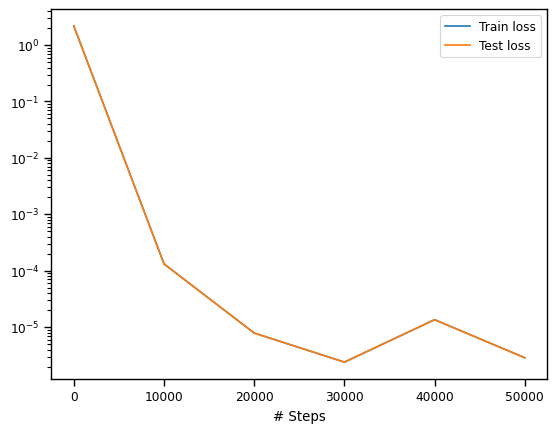

In [41]:
dde.utils.external.plot_loss_history(losshistory)

Now, the prediction with PINNs

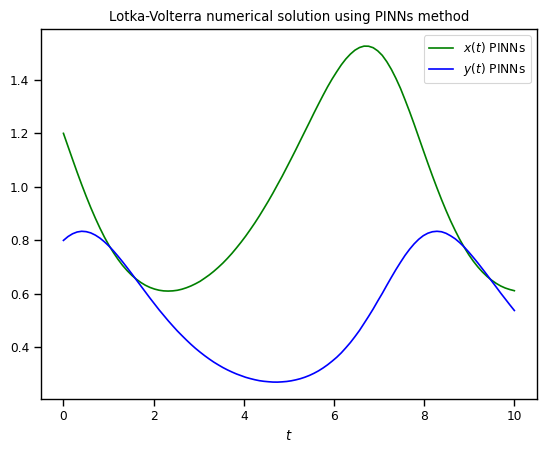

In [42]:
pinn_pred = model.predict(t_array.reshape(-1, 1))
x_pinn = pinn_pred[:, 0:1]
y_pinn = pinn_pred[:, 1:2]

plt.plot(t_array, x_pinn, color="green", label=r"$x(t)$ PINNs")
plt.plot(t_array, y_pinn, color="blue", label=r"$y(t)$ PINNs")
plt.legend()
plt.xlabel(r"$t$")
plt.title("Lotka-Volterra numerical solution using PINNs method")
plt.show()

As you can see both algorithms gave us almost identical results. One of the pros that we would like to point out about Physics-Informed neural networks is that for more complex systems you only need to change a very few things more, specifically residuals. Most of the numerical work is done automatically by machine learning libraries as `TensorFlow`, `Torch`, `JAX`, etc. so it is easy to scale it up, even better when we can take advantage of GPUs. For you, as an user, your challenge will be in pick suitable hyper-parameters (number of layers, number of neurons, activation function, number of iterations, etc.) but this also could be done by other algorithms, however these are out of the scope of this lesson.

Finally, we can compare both models and notice they are practically the same curves.

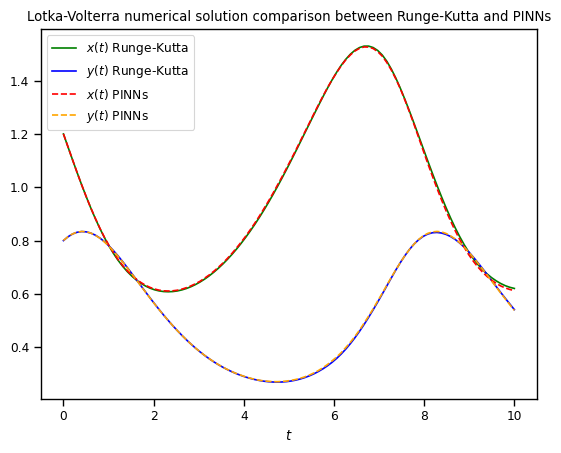

In [43]:
plt.plot(t_array, x_rungekutta, color="green", label=r"$x(t)$ Runge-Kutta")
plt.plot(t_array, y_rungekutta, color="blue", label=r"$y(t)$ Runge-Kutta")
plt.plot(t_array, x_pinn, color="red", linestyle="dashed", label=r"$x(t)$ PINNs")
plt.plot(t_array, y_pinn, color="orange", linestyle="dashed", label=r"$y(t)$ PINNs")
plt.legend()
plt.xlabel(r"$t$")
plt.title("Lotka-Volterra numerical solution comparison between Runge-Kutta and PINNs")
plt.show()